In [2]:
!gdown https://drive.google.com/drive/folders/1CIg84uv3_Br49iF-HA-lihRnNEX_IVBR --folder
!gdown https://drive.google.com/drive/folders/1zFD70aYnQvlyvm1A-EuMSY7tSSj-BKxJ --folder


!pip install nflows

Retrieving folder contents
Processing file 17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT dataset_piccolo.txt
Processing file 1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg dataset.txt
Processing file 1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL test_dataset.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT
To: /content/data/dataset_piccolo.txt
100% 78.9M/78.9M [00:00<00:00, 132MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg
From (redirected): https://drive.google.com/uc?id=1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg&confirm=t&uuid=22f517ec-8f33-408c-a727-11dc348d2e0d
To: /content/data/dataset.txt
100% 153M/153M [00:01<00:00, 149MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL
From (redirected): https://drive.google.com/uc?id=1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL&confirm=t&uuid=8453e673

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.base import InverseTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.permutations import RandomPermutation

from torch import optim
from torchsummary import summary
from torchvision import models
#from utils import our_classes

import torch

from sklearn import preprocessing
from utils.model import model_definer
#from utils.inf_eraser import inf_eraser
from utils.our_classes import Compressor
from utils.our_classes import Preprocessor

import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import torch
from os import stat
import sys

labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
unit_measure = {
    0: "GeV",
    1: "arb.",
    2: "rad.",
    3: "GeV",
    4: "",
    5: "GeV",
    6: "GeV",
    7: "GeV",
    8: "GeV",
    9: "GeV",
    10: "GeV",
    11: "GeV",
    12: "",
    13: "",
    14: "",
    15: "",
    16: "",
    17: "",
    18: "",
    19: "GeV",
    20: "GeV",
    21: "GeV",
    22: "",
    23: "",
}
num_features = len(labels_map)

index_int = np.append(np.arange(12,19),[22,23])
index_float = np.append(np.arange(0,12),np.arange(19,22))

In [4]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print(L)

472827


In [5]:
###LOG SU 0 E 3,STD SU TUTTE E QUATTRO LE FEATURES E QUANTILE SU 1,2

x = x[:int(L/16),:] #da mettere al massimo a 8 in colab
xval = xval[:len(x),:]
xtest = xtest[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest = xtest[:,0:num_features]

print('Eventi =',len(x))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))


preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([1,2]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Eventi = 29551
attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



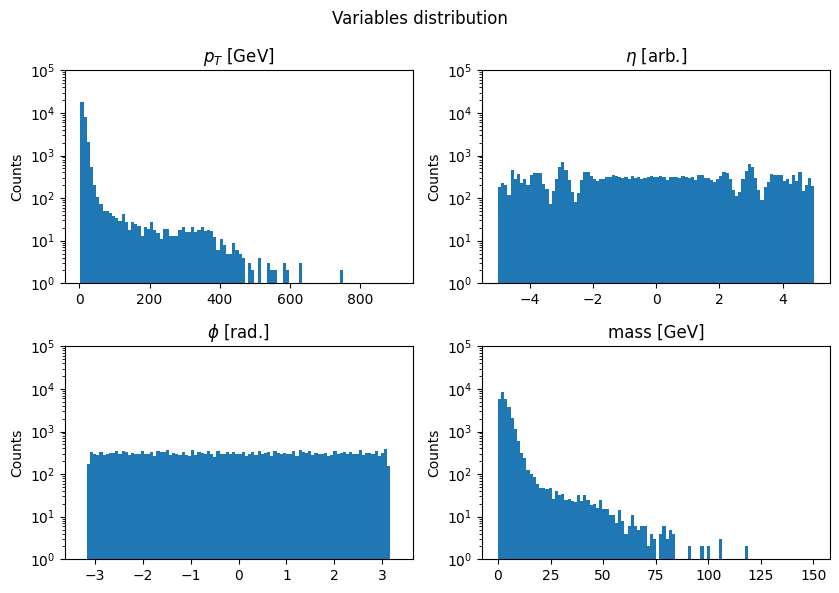

In [6]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins)
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
!mkdir figures
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

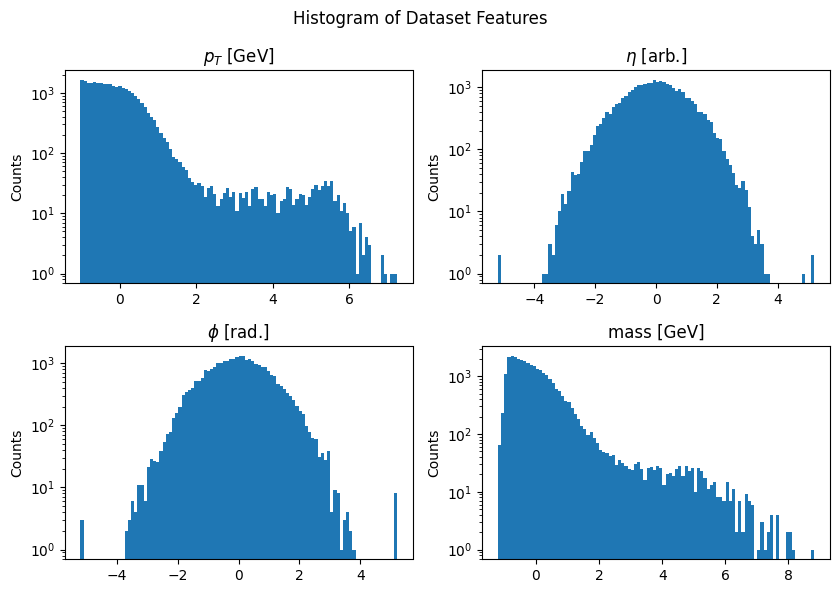

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Histogram of Dataset Features")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_ylabel("Counts")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylabel("Counts")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1, 0].set_ylabel("Counts")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)
#mettere unità di misura


In [53]:
###Model Optimization

range_iterations = np.linspace(2,6,5,dtype=int)
range_hidden_features = np.linspace(32,256,6,dtype=int)

epochs = 100 #andrà messo a 10000 su colab

loss_storer = np.zeros(shape=(len(range_iterations),len(range_hidden_features),epochs))
loss_storer_val = np.zeros(shape=(len(range_iterations),len(range_hidden_features),epochs))

for j in range(len(range_iterations)):
  it = range_iterations[j]
  for k in range(len(range_hidden_features)):
    hf = range_hidden_features[k]
    flow, optimizer = model_definer(num_features=num_features, num_iterations=it, hidden_features=hf)

    for i in range(epochs):
      optimizer.zero_grad()
      loss = -flow.log_prob(inputs=xt).mean()
      loss_val = -flow.log_prob(inputs=xval).mean()
      loss.backward()
      optimizer.step()
      loss_storer[j,k,i] = loss.cpu().detach().numpy()
      loss_storer_val[j,k,i] = loss_val.cpu().detach().numpy()

Numero di parametri allenabili = 9296
Numero di parametri allenabili = 48808
Numero di parametri allenabili = 121258
Numero di parametri allenabili = 226108
Numero di parametri allenabili = 363358
Numero di parametri allenabili = 533008
Numero di parametri allenabili = 13944
Numero di parametri allenabili = 73212
Numero di parametri allenabili = 181887
Numero di parametri allenabili = 339162
Numero di parametri allenabili = 545037
Numero di parametri allenabili = 799512
Numero di parametri allenabili = 18592
Numero di parametri allenabili = 97616
Numero di parametri allenabili = 242516
Numero di parametri allenabili = 452216
Numero di parametri allenabili = 726716
Numero di parametri allenabili = 1066016
Numero di parametri allenabili = 23240
Numero di parametri allenabili = 122020
Numero di parametri allenabili = 303145
Numero di parametri allenabili = 565270
Numero di parametri allenabili = 908395
Numero di parametri allenabili = 1332520
Numero di parametri allenabili = 27888
Numero 

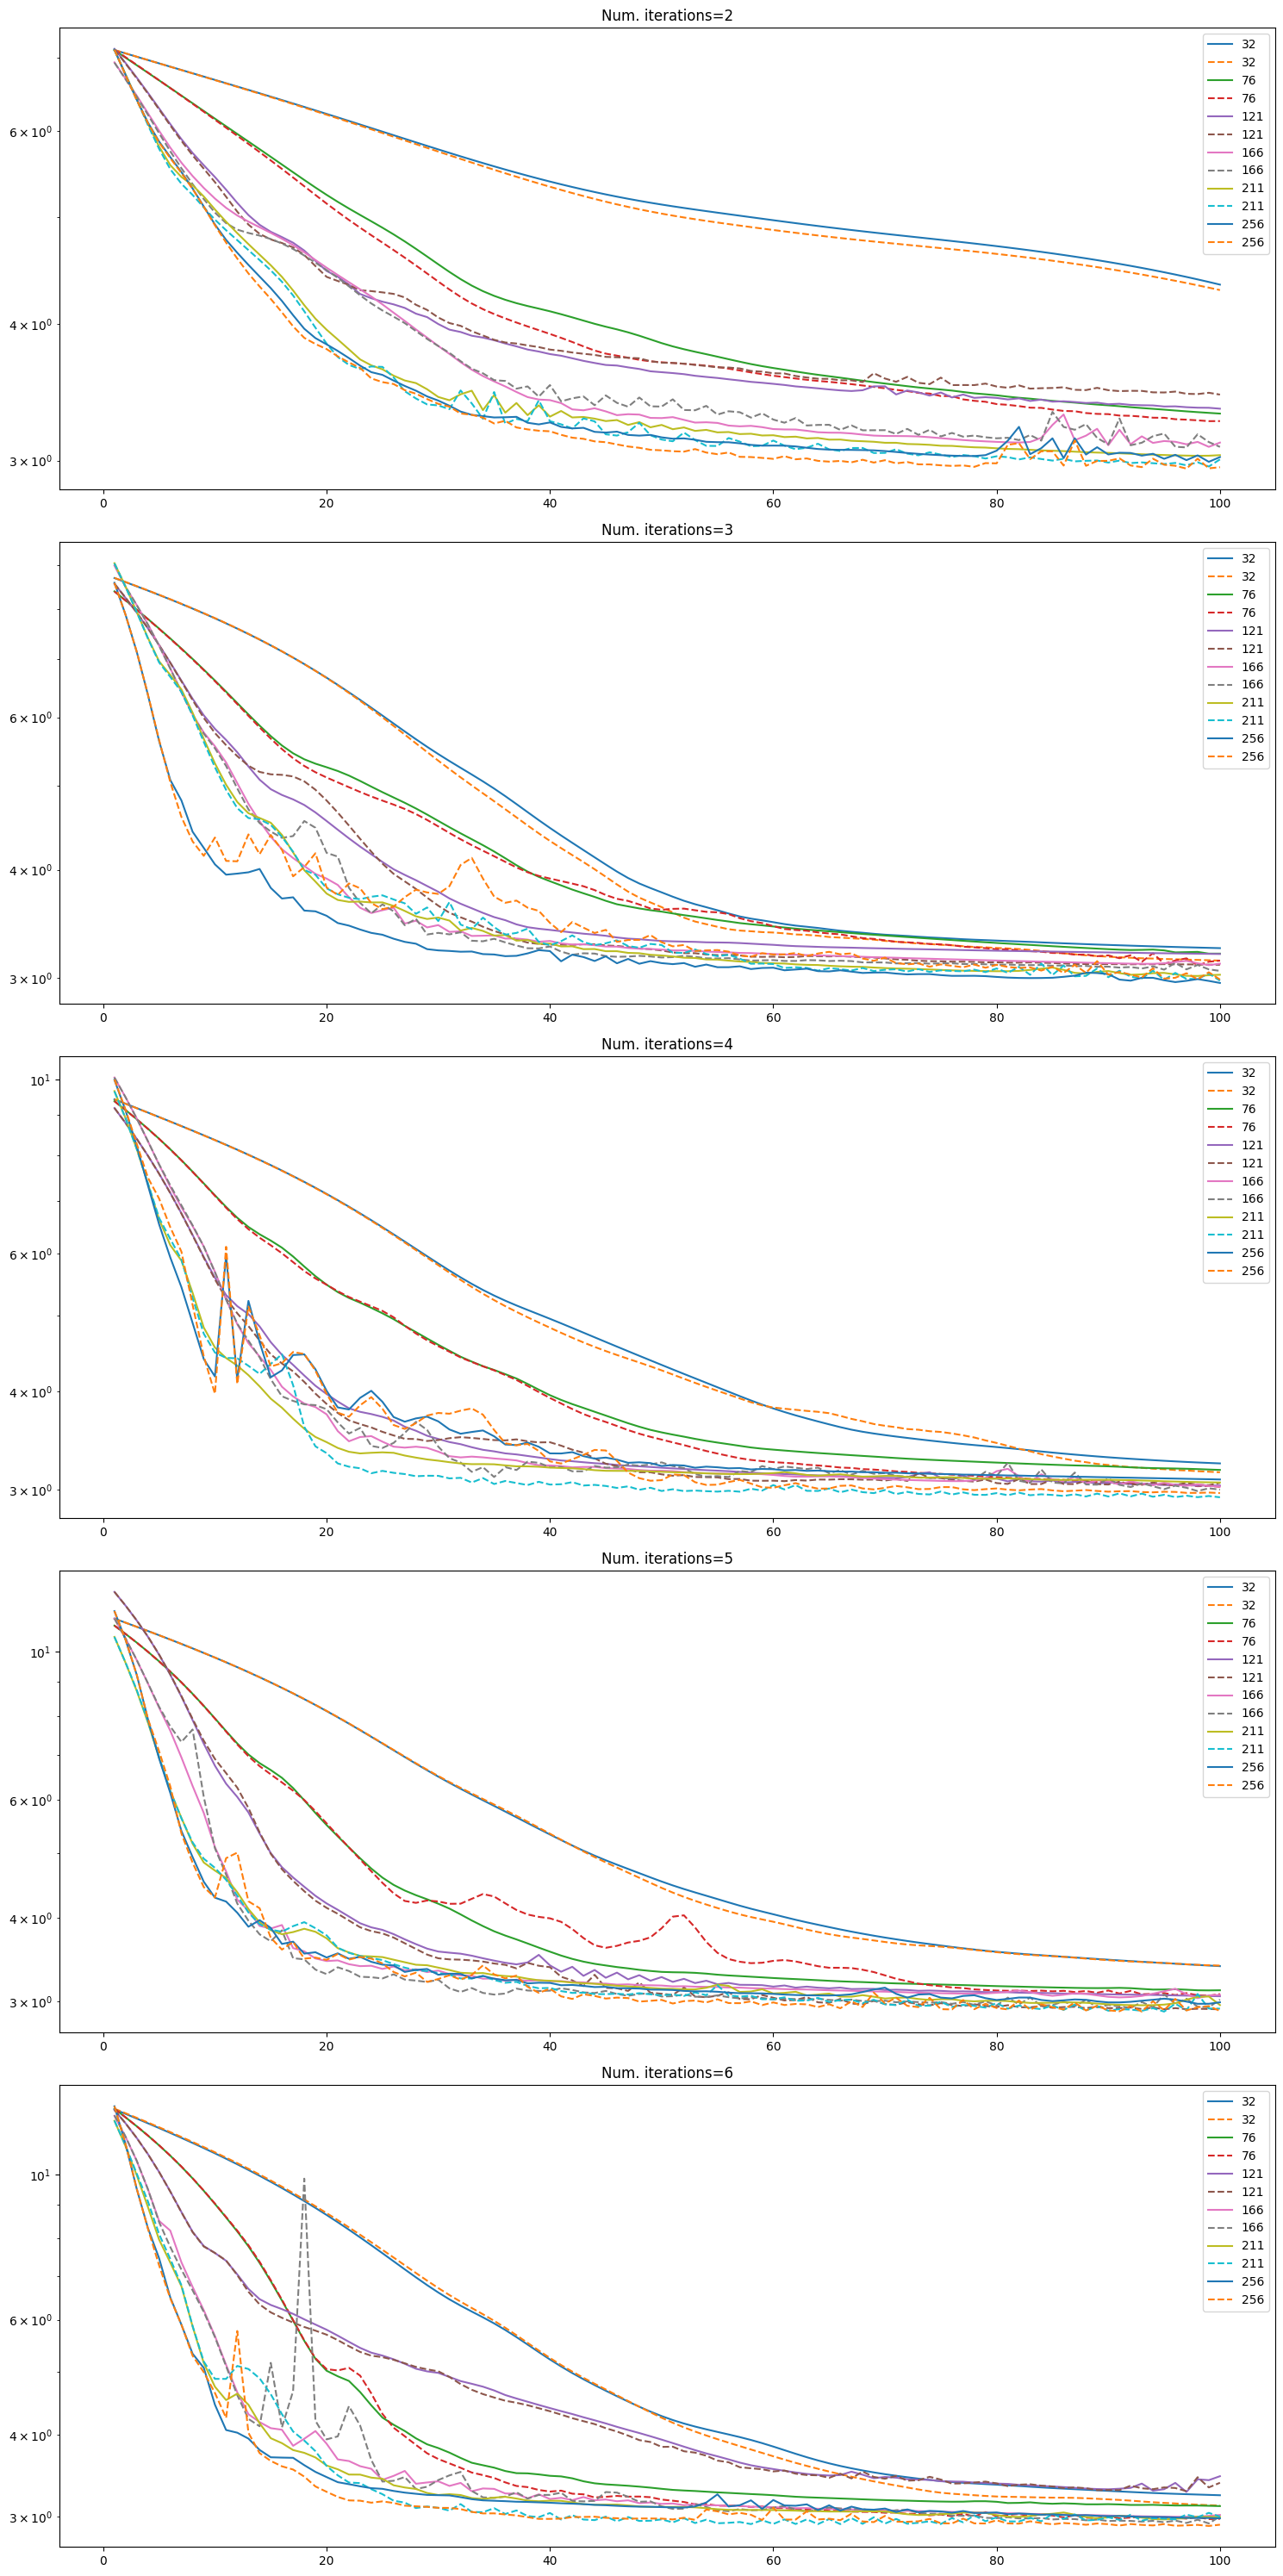

In [57]:
figlosses,axs = plt.subplots(len(range_iterations),1,figsize=(15,30))

for j in range(len(range_iterations)):
  for h in range(len(range_hidden_features)):
    axs[j].set_title('Num. iterations={}'.format(range_iterations[j]))
    axs[j].plot(range(1,epochs+1),loss_storer[j,h,:],label=range_hidden_features[h])
    axs[j].plot(range(1,epochs+1),loss_storer_val[j,h,:],label=range_hidden_features[h],ls='--')
    axs[j].set_yscale('log')
    axs[j].legend()


figlosses.tight_layout()
plt.show()
figlosses.savefig('figures/Model_optimization.pdf',dpi=190)




In [8]:
flow, optimizer = model_definer(num_features=num_features, num_iterations=6, hidden_features=128)

Numero di parametri allenabili = 406320


50 tensor(3.1510, device='cuda:0', grad_fn=<NegBackward0>)
100 tensor(3.0127, device='cuda:0', grad_fn=<NegBackward0>)
150 tensor(2.9193, device='cuda:0', grad_fn=<NegBackward0>)
200 tensor(2.8786, device='cuda:0', grad_fn=<NegBackward0>)
250 tensor(2.8525, device='cuda:0', grad_fn=<NegBackward0>)
300 tensor(2.8266, device='cuda:0', grad_fn=<NegBackward0>)
350 tensor(2.8275, device='cuda:0', grad_fn=<NegBackward0>)
400 tensor(2.8040, device='cuda:0', grad_fn=<NegBackward0>)
450 tensor(2.8000, device='cuda:0', grad_fn=<NegBackward0>)
500 tensor(2.7962, device='cuda:0', grad_fn=<NegBackward0>)
550 tensor(2.7997, device='cuda:0', grad_fn=<NegBackward0>)
600 tensor(2.7827, device='cuda:0', grad_fn=<NegBackward0>)
650 tensor(2.7763, device='cuda:0', grad_fn=<NegBackward0>)
700 tensor(2.7769, device='cuda:0', grad_fn=<NegBackward0>)
750 tensor(2.7870, device='cuda:0', grad_fn=<NegBackward0>)
800 tensor(2.7693, device='cuda:0', grad_fn=<NegBackward0>)
850 tensor(2.7722, device='cuda:0', grad_

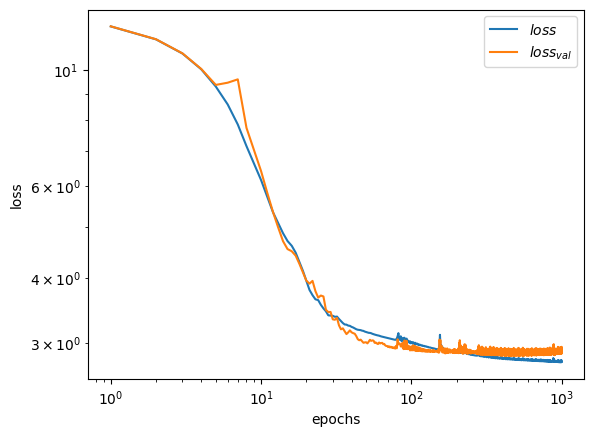

In [9]:
epochs = 100 #andrà messo a 10000 su colab

figloss=plt.figure()
loss_values = []
loss_validation = []
for i in range(epochs):
  optimizer.zero_grad()
  loss = -flow.log_prob(inputs=xt).mean()
  loss_val = -flow.log_prob(inputs=xval).mean()
  loss.backward()
  optimizer.step()
  loss_values.append(loss.cpu().detach().numpy())
  loss_validation.append(loss_val.cpu().detach().numpy())
  if (i+1) % 50 == 0:
    print(i+1,loss)

plt.plot(range(1, epochs+1), loss_values, label='$loss$')
plt.plot(range(1, epochs+1), loss_validation,label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

In [10]:
sample = flow.sample(int(len(x)))
sample = sample.cpu().detach().numpy()
sample = x_preprocessor.backward(sample)

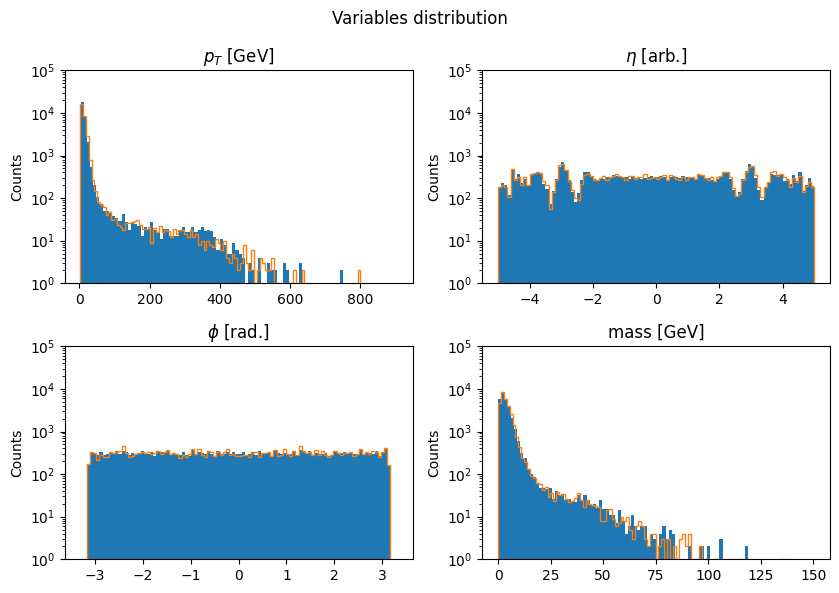

In [11]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins)
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step')
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step')
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins)
axs[1, 1].hist(sample[:,3],bins=n_bins,histtype='step')
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_reconstruction.pdf',dpi=190)

In [12]:
#training
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

In [13]:
###COMPRESSING###
x_compressor = Compressor(flow=flow, N=11, limit=3)
x_compressed = x_compressor.compress(xt)
x_decompressed = x_compressor.decompress(x_compressed)
x_decompressed = x_preprocessor.backward(x_decompressed)

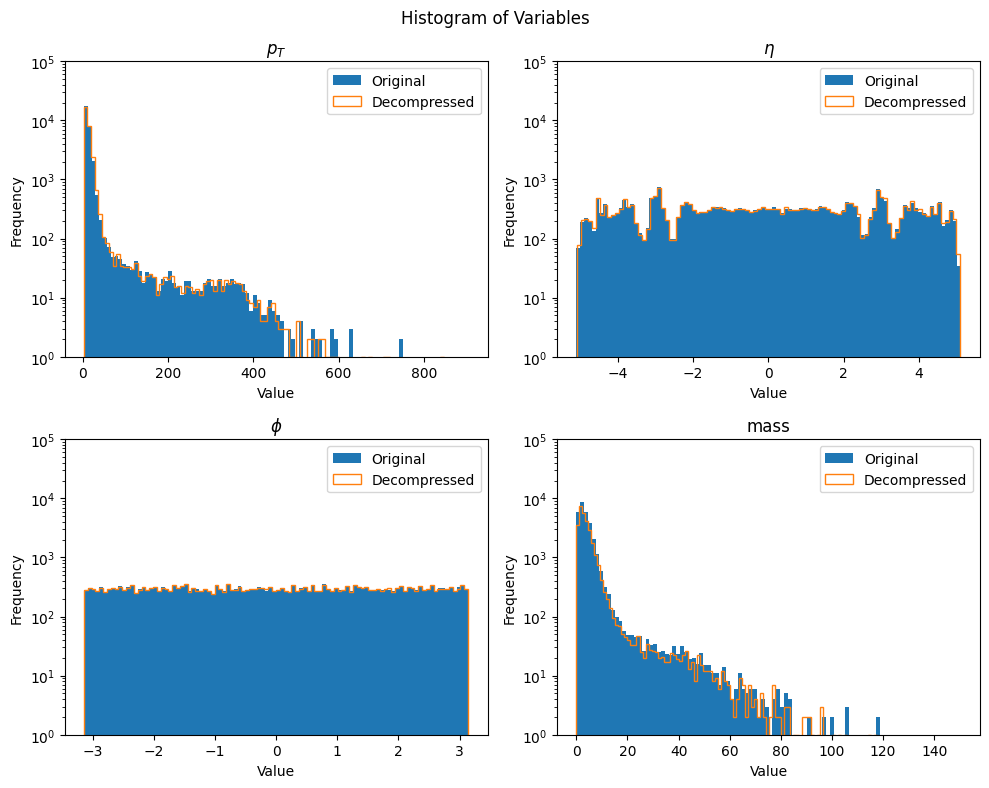

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Histogram of Variables")

n_bins = 100

axs[0, 0].hist(x[:, 0], bins=n_bins, label='Original',  log=True)
axs[0, 0].hist(x_decompressed[:, 0], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_xlabel("Value")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].set_ylim(1,10e4)
axs[0, 0].legend()

axs[0, 1].hist(x[:, 1], bins=n_bins, label='Original', log=True)
axs[0, 1].hist(x_decompressed[:, 1], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_xlabel("Value")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].set_ylim(1,10e4)
axs[0, 1].legend()

axs[1, 0].hist(x[:, 2], bins=n_bins, label='Original', log=True)
axs[1, 0].hist(x_decompressed[:, 2], bins=n_bins, label='Decompressed',histtype='step')
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_xlabel("Value")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:, 3], bins=n_bins, label='Original', log=True)
axs[1, 1].hist(x_decompressed[:, 3], bins=n_bins, label='Decompressed', histtype='step')
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_xlabel("Value")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_comparison.pdf', dpi=190)


<ipython-input-15-db81f2e4f18b>:22: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-15-db81f2e4f18b>:22: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


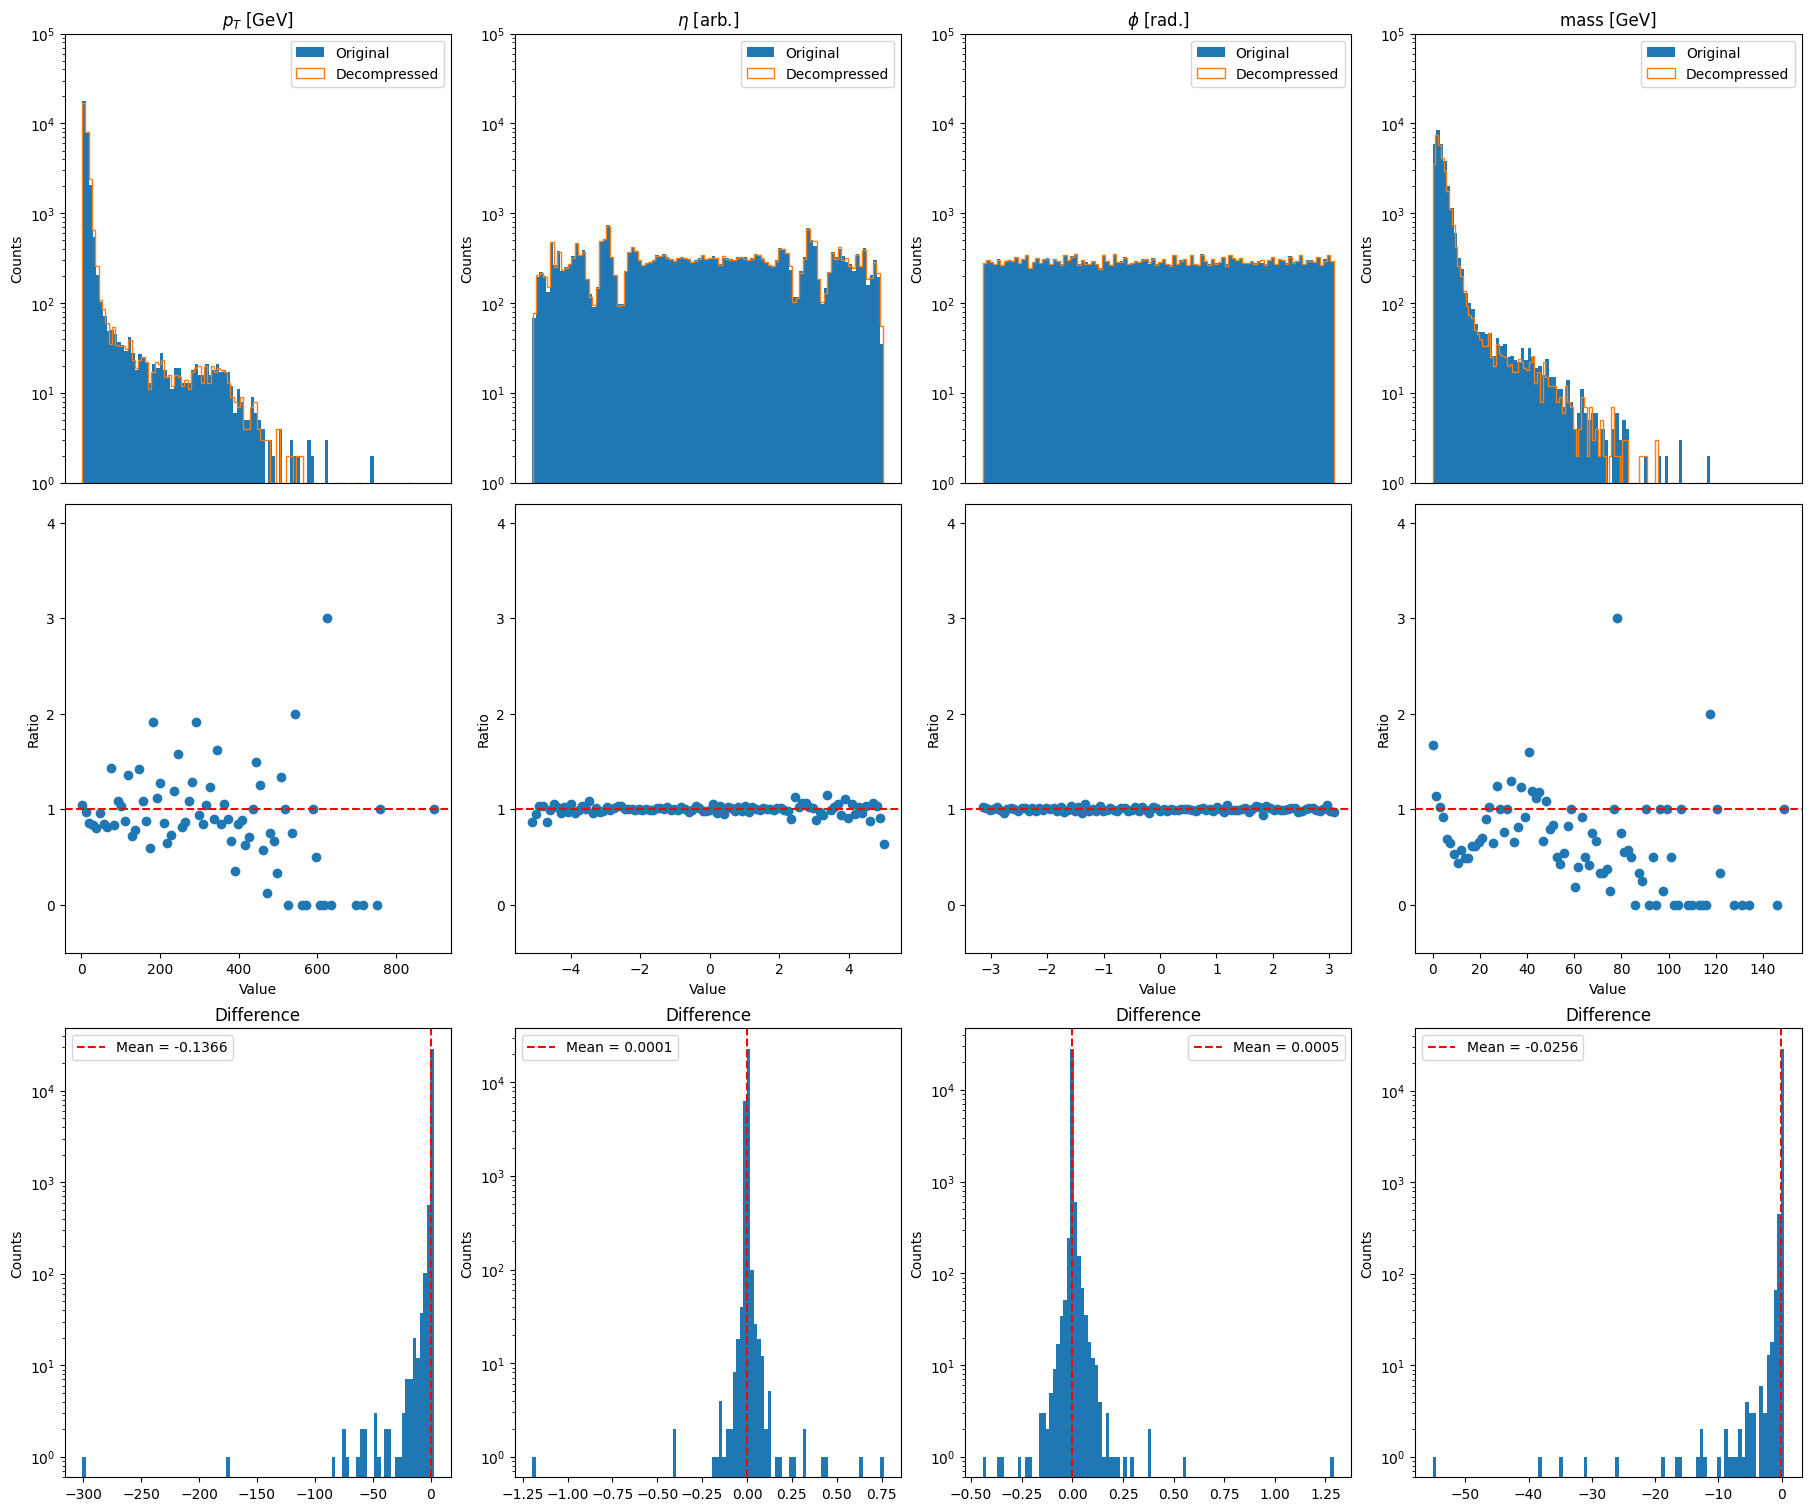

In [15]:
difference = x_decompressed-x

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots")

n_bins = 100

for i in range(4):
    y = []
    y.append(x[:, i])
    y.append(x_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1,10e4)
    axs[0, i].get_xaxis().set_ticks([])


    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio")
    axs[1, i].set_ylim(-0.5,4.2)


    axs[2, i].hist(difference[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference.pdf', dpi=190)

In [16]:
with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")


In [17]:
size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio =',size_input/size_compressed)

Size of input file = 1.6123056411743164 MB
Size of output file = 1.1355781555175781 MB
Size of compressed file = 0.5580530166625977 MB
Compression ratio = 2.8891621280297217


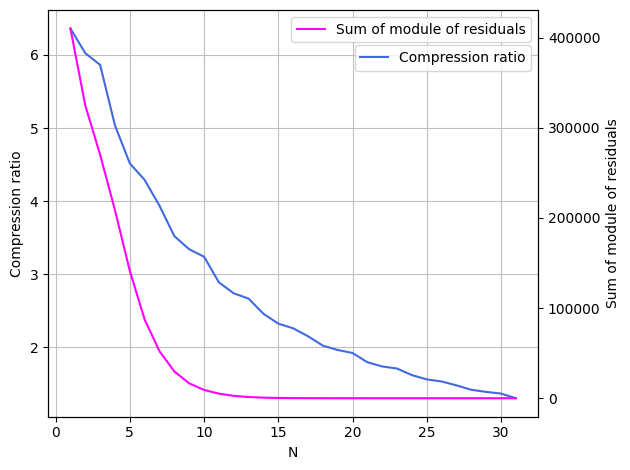

In [18]:
RR = []
residui = []


for k in range(1,32):
    x_compressor_k = Compressor(flow=flow, N=k, limit=3)
    x_compressed_k = x_compressor_k.compress(xt)
    x_decompressed_k = x_compressor_k.decompress(x_compressed_k)
    x_decompressed_k = x_preprocessor.backward(x_decompressed_k)

    with open('output_k.txt', 'w') as output:
        for i in range(len(x)):
            output.write(' '.join(str(x_decompressed_k[i, j]) for j in range(x_decompressed_k.shape[1])) + "\n")

    with open('compressed_k.txt', 'w') as compressed:
        for i in range(len(x)):
            compressed.write(' '.join(str(x_compressed_k[i, j]) for j in range(x_compressed_k.shape[1])) + "\n")

    size_output_k = stat('output_k.txt').st_size
    size_compressed_k = stat('compressed_k.txt').st_size

    r_k = size_input/size_compressed_k
    RR.append(r_k)

    residui_k = np.sum(np.abs(x-x_decompressed_k))
    residui.append(residui_k)


fig, ax1 = plt.subplots()
ax1.set_xlabel('N')
ax1.set_ylabel('Compression ratio')
ax1.plot(range(1,k+1),RR, c='royalblue',label='Compression ratio')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Sum of module of residuals')
ax2.plot(range(1,k+1),residui, c='fuchsia',label='Sum of module of residuals')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.93))
ax2.legend(loc=0)
ax1.grid(c='silver')
plt.show()

fig.savefig('figures/Compression_ratio.pdf',dpi=190)

In [19]:
###TESTING

xtest_preprocessor = Preprocessor(preprocessor_settings)
xtest_preprocessed = xtest_preprocessor.forward(xtest)
xtest_compressed = x_compressor.compress(xtest_preprocessed)
xtest_decompressed = x_compressor.decompress(xtest_compressed)
xtest_decompressed = xtest_preprocessor.backward(xtest_decompressed)

with open('test_input.txt', 'w') as test_input:
    for i in range(len(xtest)):
        test_input.write(' '.join(str(xtest[i, j]) for j in range(xtest.shape[1])) + "\n")

with open('test_compressed.txt', 'w') as test_compressed:
        for i in range(len(xtest)):
            test_compressed.write(' '.join(str(xtest_compressed[i, j]) for j in range(xtest_compressed.shape[1])) + "\n")

size_test_input = stat('test_input.txt').st_size
size_test_compressed = stat('test_compressed.txt').st_size
r_test = size_test_input/size_test_compressed
print('Compression ratio for test =',r_test)

Compression ratio for test = 2.9961278448306374


<ipython-input-20-e5af39f7e932>:22: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-20-e5af39f7e932>:22: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


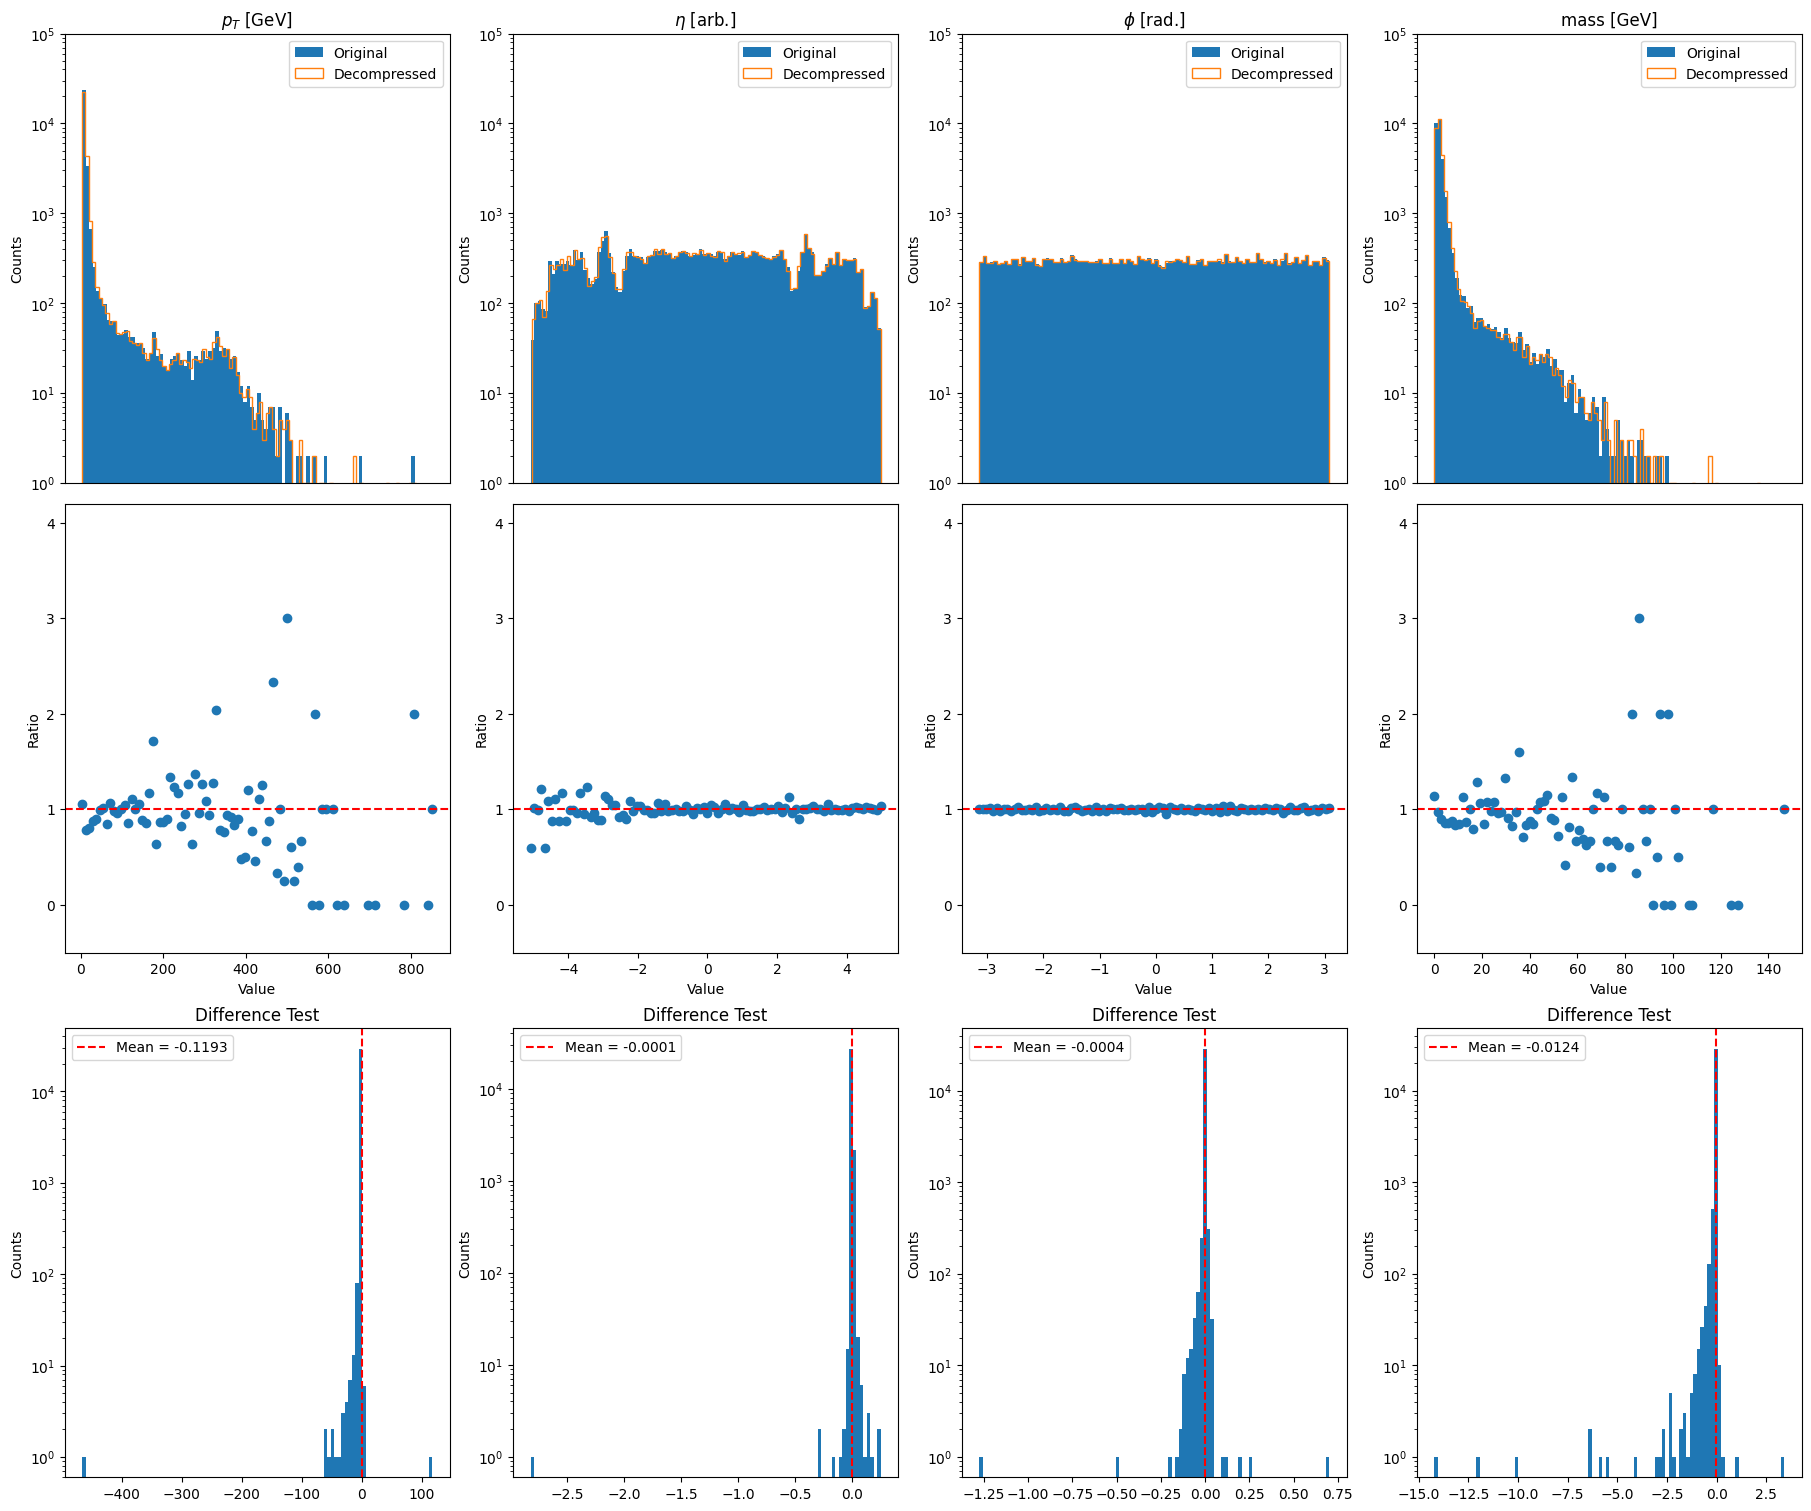

In [20]:
difference_test = xtest_decompressed-xtest

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots for Test")

n_bins = 100

for i in range(4):
    y = []
    y.append(xtest[:, i])
    y.append(xtest_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1,10e4)
    axs[0, i].get_xaxis().set_ticks([])


    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio")
    axs[1, i].set_ylim(-0.5,4.2)


    axs[2, i].hist(difference_test[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference Test")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference_test[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference_test[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference_test.pdf', dpi=190)